# Color Analysis of Images using K-means Clustering

This notebook performs color analysis on images using K-means clustering.
It extracts dominant colors, visualizes results, and matches colors to named colors.
The methods implemented include Elbow, Silhouette, and Gap Statistic for optimal cluster selection.


# 1. Importing necessary Libraries


In [ ]:
import numpy as np  # Numerical operations
import pandas as pd  # Data manipulation and analysis
import matplotlib.pyplot as plt  # Plotting
from mpl_toolkits.mplot3d import Axes3D  # 3D plotting
import cv2  # Image processing
from sklearn.cluster import KMeans  # K-means clustering algorithm
from sklearn.metrics import silhouette_score  # Silhouette score for clustering evaluation
from kneed import KneeLocator  # Finding the "knee" in a curve
import webcolors  # Working with color names
from collections import Counter  # Counting hashable objects
import json  # JSON manipulation
import math  # Mathematical functions
import warnings  # Warning control

# 2. Define the helper functions for coneverting RGB to HEX and vice versa


In [ ]:
# Converts a color from RGB format to HEX format
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))
# Loads an image from the given path and converts it to RGB color space
def load_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"No image found at {image_path}")
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Preprocesses the image by resizing it and converting it to a format suitable for analysis
def preprocess_image(image, target_size=(600, 400)):
    resized = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)
    return resized.reshape(-1, 3)
# Loads and preprocesses the image, and optionally displays the original and processed image
def load_and_preprocess(image_path, plot=True):
    original = load_image(image_path)
    processed = preprocess_image(original)
    if plot:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.imshow(original)
        ax1.set_title("Original Image")
        ax1.axis('off')
        ax2.imshow(processed.reshape(400, 600, 3))
        ax2.set_title("Preprocessed Image")
        ax2.axis('off')
        plt.show()
    return original, processed

# Extracts the dominant colors from the image using the K-means algorithm
def extract_colors(image, n_colors, n_init=10, random_state=42):
    # Apply K-means clustering to find dominant colors
    kmeans = KMeans(n_clusters=n_colors, n_init=n_init, random_state=random_state)
    # Assigns each pixel to the closest cluster center
    labels = kmeans.fit_predict(image)
    
    # Count how many pixels belong to each cluster using Counter
    counts = Counter(labels)
    
    # Get the RGB values of cluster centers (dominant colors)
    center_colors = kmeans.cluster_centers_
    
    # Order colors by their frequency of occurrence in the image
    ordered_colors = [center_colors[i] for i in counts.keys()]
    
    # Convert to integer RGB values and hex codes
    rgb_colors = [color.astype(int) for color in ordered_colors]
    hex_colors = [RGB2HEX(color) for color in rgb_colors]
    
    return rgb_colors, hex_colors, labels

# 3 Load color names


In [ ]:
with open('colors_name.json') as json_file:
    json_data = json.load(json_file)

# 4 Define color extraction and naming functions


In [ ]:
# Finds the name of a color based on the HEX code
def get_colour_name(requested_hex):
    try:
        closest_name = actual_name = json_data[requested_hex.lstrip('#')]
    except KeyError:
        closest_name = closest_colour(webcolors.hex_to_rgb(requested_hex))
        actual_name = None
    return actual_name, closest_name

# Finds the closest color to the requested color based on Euclidean distance
def closest_colour(requested_colour):
    # Calculate the Euclidean distance between the requested color and all available colors
    min_colors = {}
    for key, name in json_data.items():
        # Convert hex to RGB to calculate Euclidean distance
        r_c, g_c, b_c = webcolors.hex_to_rgb("#"+key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colors[math.sqrt(rd + gd + bd)] = name
        # Return the color name with the smallest Euclidean distance
    return min_colors[min(min_colors.keys())]

# 5 Define visualization functions


In [ ]:
# Plots a bar with the dominant colors and their names
def plot_color_bar(hex_colors, color_names):
    fig, ax = plt.subplots(figsize=(12, 2))
    for i, (hex_color, name) in enumerate(zip(hex_colors, color_names)):
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, facecolor=hex_color))
        ax.text(i+0.5, -0.1, name, ha='center', va='center', rotation=45)
    ax.set_xlim(0, len(hex_colors))
    ax.set_ylim(-0.5, 1.5)
    ax.axis('off')
    plt.title('Dominant Colors')
    plt.tight_layout()
    plt.show()

# Plots a 3D scatter plot of the image's colors
def plot_3d_scatter(image):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    pixel_colors = image.reshape(-1, 3) / 255.0
    ax.scatter(pixel_colors[:, 0], pixel_colors[:, 1], pixel_colors[:, 2], c=pixel_colors, s=1)
    ax.set_xlabel('Red')
    ax.set_ylabel('Green')
    ax.set_zlabel('Blue')
    plt.title('3D RGB Color Space')
    plt.show()

# 6 Implement Elbow Method


In [ ]:
# Apply the elbow method to find the optimal number of clusters
def elbow_method(image, max_k=10):
    distortions = []
    K = range(1, max_k + 1)
    
    # Calculate distortion for different k values
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(image)
        distortions.append(kmeans.inertia_)
    
    # Use KneeLocator to find the elbow point
    kn = KneeLocator(K, distortions, curve='convex', direction='decreasing')
    optimal_k = kn.elbow
    
    # Plot the elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('Elbow Method for Optimal k')
    plt.vlines(optimal_k, plt.ylim()[0], plt.ylim()[1], colors='r', linestyles='dashed', label=f'Optimal k={optimal_k}')
    plt.legend()
    plt.show()
    
    return optimal_k

# 7 Implement Silhouette Method


In [ ]:
# Apply the Silhouette method to find the optimal number of clusters
def silhouette_method(image, max_k=10):
    silhouette_scores = []
    K = range(2, max_k + 1)
    
    # Calculate silhouette score for different k values
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(image)
        score = silhouette_score(image, labels)
        silhouette_scores.append(score)
    
    # Find k with highest silhouette score
    optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2
    
    # Plot silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(K, silhouette_scores, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Analysis for Optimal k')
    plt.vlines(optimal_k, plt.ylim()[0], plt.ylim()[1], colors='r', linestyles='dashed', label=f'Optimal k={optimal_k}')
    plt.legend()
    plt.show()
    
    return optimal_k

# 8 Implement Gap Statistic Method


In [ ]:
# Applies the Gap Statistic method to find the optimal number of clusters"
def gap_statistic(image, nrefs=3, maxClusters=15):
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount': [], 'gap': []})
    for gap_index, k in enumerate(range(1, maxClusters)):
        # Calculate the gap statistic for k
        refDisps = np.zeros(nrefs)
        for i in range(nrefs):
            # Generate random reference data set
            randomReference = np.random.random_sample(size=image.shape) 
            km = KMeans(k) # Fit the KMeans model to the reference data set
            km.fit(randomReference) 
            refDisp = km.inertia_ # Calculate the dispersion of the reference data set
            refDisps[i] = refDisp # Fit the KMeans model to the actual data set
        km = KMeans(k)
        km.fit(image)
        origDisp = km.inertia_
        gap = np.log(np.mean(refDisps)) - np.log(origDisp) # Calculate the gap statistic
        gaps[gap_index] = gap # Store the results 
        resultsdf = pd.concat([resultsdf, pd.DataFrame({'clusterCount': [k], 'gap': [gap]})], ignore_index=True) 
    optimal_k = gaps.argmax() + 1 
    # Plot the gap statistic curve
    plt.figure(figsize=(10, 6))
    plt.plot(resultsdf['clusterCount'], resultsdf['gap'], linestyle='--', marker='o', color='b')
    plt.xlabel('k')
    plt.ylabel('Gap Statistic')
    plt.title('Gap Statistic vs. K')
    plt.vlines(optimal_k, plt.ylim()[0], plt.ylim()[1], colors='r', linestyles='dashed', label=f'Optimal k={optimal_k}')
    plt.legend()
    plt.show()
    return optimal_k

# 9 Define method execution and result display function


In [ ]:
def run_method(image, method_func, method_name):
    optimal_k = method_func(image) # Find optimal k
    rgb_colors, hex_colors, labels = extract_colors(image, optimal_k) # Extract colors 
    color_names = [get_colour_name(hex_color)[1] for hex_color in hex_colors] # Get color names 
    # Display results
    print(f"\n{method_name} Results:")
    print(f"Optimal k: {optimal_k}")
    print("Color names for each hex code:")
    for hex_color, name in zip(hex_colors, color_names):
        print(f"Hex code: {hex_color}, Color name: {name}")
    
    plot_color_bar(hex_colors, color_names)
    
    # Add pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(np.bincount(labels), colors=hex_colors, labels=color_names, autopct='%1.1f%%')
    plt.title(f'Color Distribution ({method_name})')
    plt.show()
    
    # Add cluster visualization
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(image[:, 0], image[:, 1], image[:, 2], c=labels, cmap='viridis')
    ax.set_xlabel('Red')
    ax.set_ylabel('Green')
    ax.set_zlabel('Blue')
    plt.colorbar(scatter)
    plt.title(f'K-means Clustering on Image ({method_name})')
    plt.show()
    
    return optimal_k

# 10 Define main analysis function


In [ ]:
def main_analysis(image_path):
    original, processed = load_and_preprocess(image_path)
    plot_3d_scatter(processed)
    
    # Run each method separately
    k_elbow = run_method(processed, elbow_method, "Elbow Method")
    k_silhouette = run_method(processed, silhouette_method, "Silhouette Method")
    k_gap = run_method(processed, gap_statistic, "Gap Statistic Method")
    
    # Calculate average optimal k
    k_average = int(np.mean([k_elbow, k_silhouette, k_gap]))
    print(f"\nAverage optimal k: {k_average}")
    
    # Run k-means with k=3 for consistency with subsequent analysis
    print("\nRunning k-means with k=3 for consistency with the next chapter:")
    rgb_colors, hex_colors, labels = extract_colors(processed, 3)
    color_names = [get_colour_name(hex_color)[1] for hex_color in hex_colors]
    
    print("Color names for k=3:")
    for hex_color, name in zip(hex_colors, color_names):
        print(f"Hex code: {hex_color}, Color name: {name}")
    
    plot_color_bar(hex_colors, color_names)
    
    # Add pie chart for k=3
    plt.figure(figsize=(8, 8))
    plt.pie(np.bincount(labels), colors=hex_colors, labels=color_names, autopct='%1.1f%%')
    plt.title('Color Distribution (k=3)')
    plt.show()
    
    # Visualize k-means clustering results with k=3
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(processed[:, 0], processed[:, 1], processed[:, 2], c=labels, cmap='viridis')
    ax.set_xlabel('Red')
    ax.set_ylabel('Green')
    ax.set_zlabel('Blue')
    
    # Plot centroids to show cluster centers
    centroids = KMeans(n_clusters=3, random_state=42).fit(processed).cluster_centers_
    ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c='red', s=200, alpha=0.75, label='Centroids')
    
    plt.colorbar(scatter)
    plt.title('K-means Clustering on Image (k=3)')
    plt.legend()
    plt.show()
    
#11 Execute main analysis
main_analysis(r'C:\Biography\ArtEmotionalPalette-AI\images_jpg\colors.jpg')

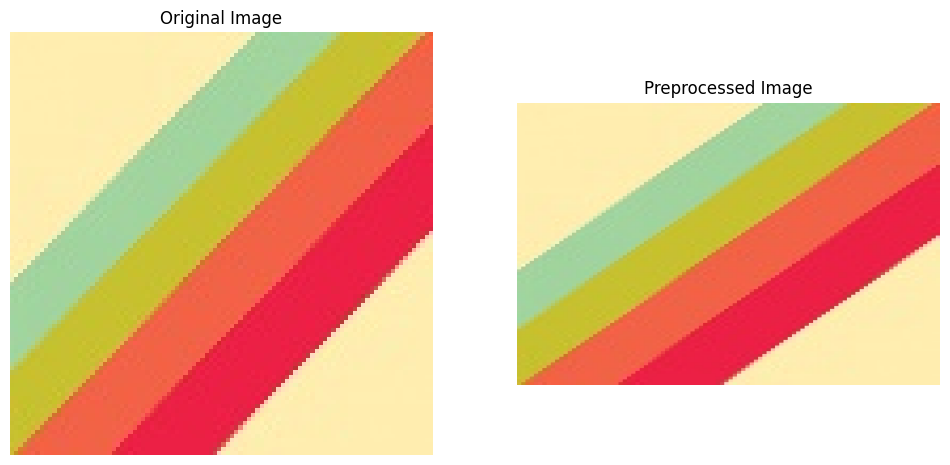

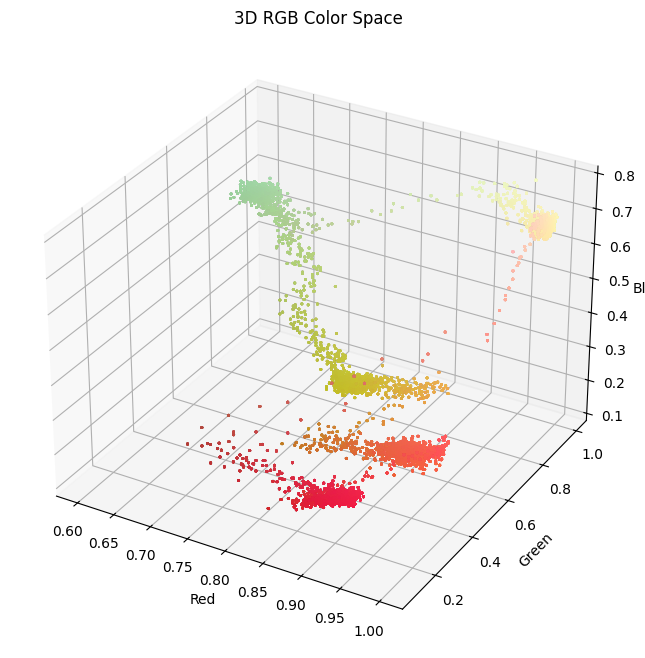

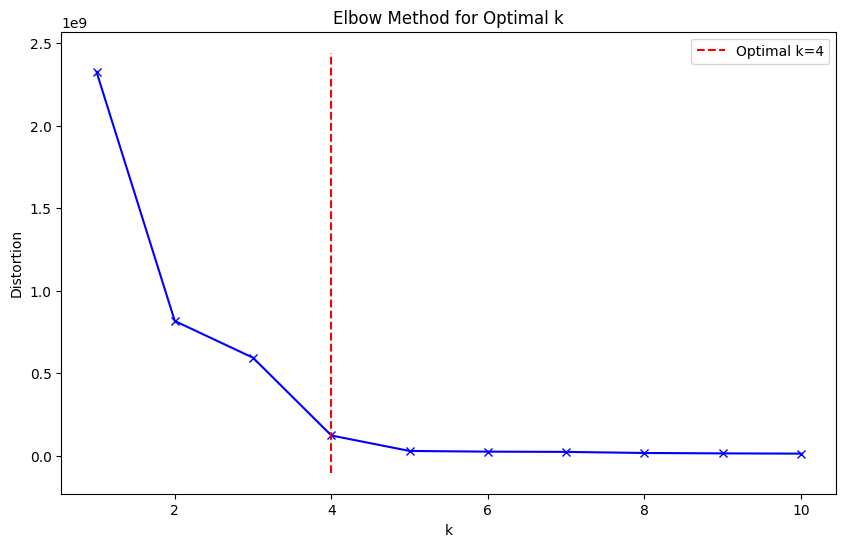


Elbow Method Results:
Optimal k: 4
Color names for each hex code:
Hex code: #fdecaf, Color name: Banana Mania
Hex code: #a3d29a, Color name: Granny Smith Apple
Hex code: #c8be32, Color name: Earls Green
Hex code: #ed4544, Color name: Sunset Orange


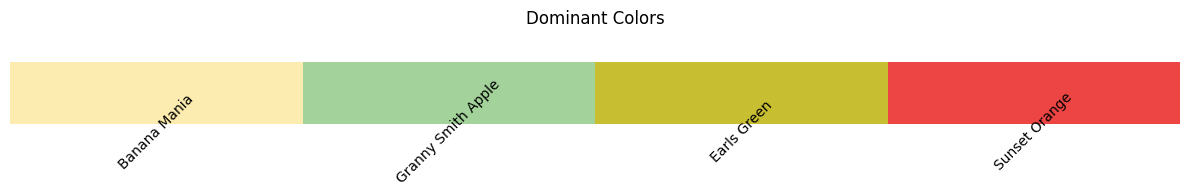

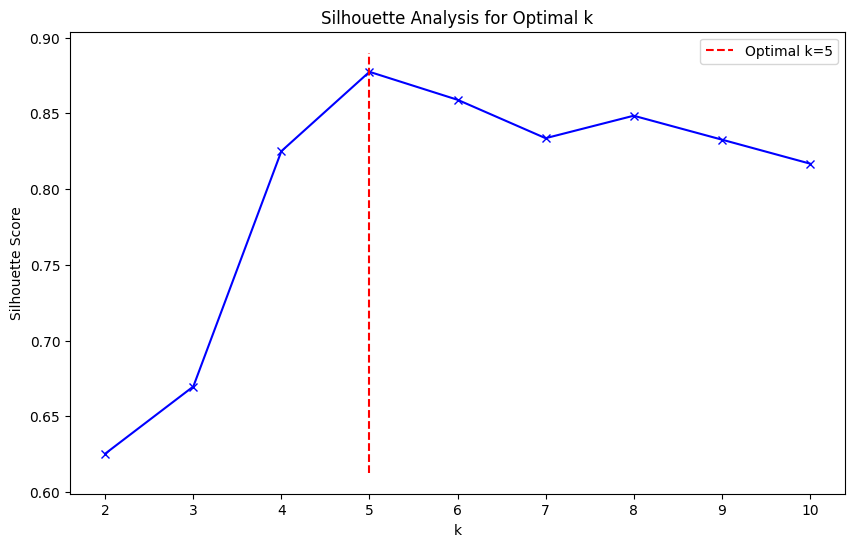


Silhouette Method Results:
Optimal k: 5
Color names for each hex code:
Hex code: #fdecaf, Color name: Banana Mania
Hex code: #a3d29a, Color name: Granny Smith Apple
Hex code: #c7bf32, Color name: Earls Green
Hex code: #f06345, Color name: Outrageous Orange
Hex code: #e92143, Color name: Alizarin Crimson


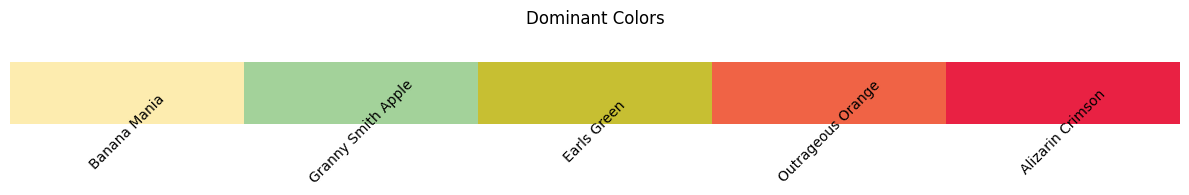

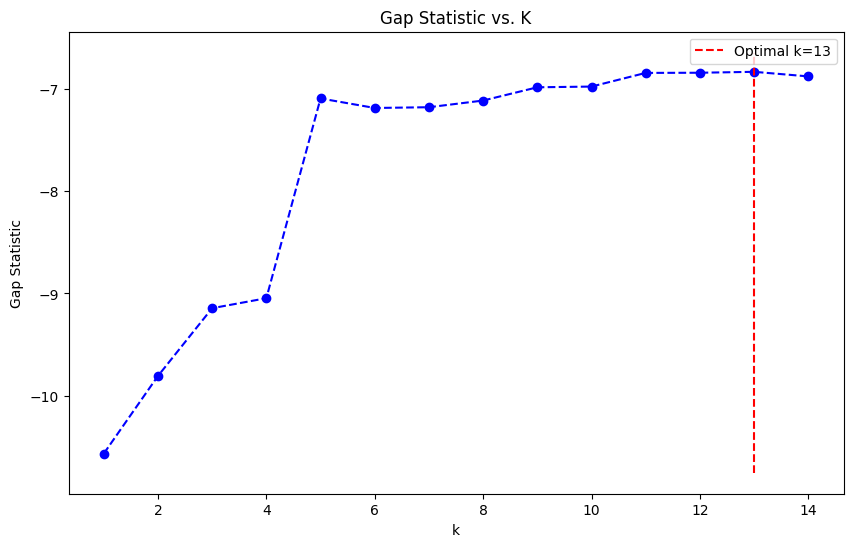


Gap Statistic Method Results:
Optimal k: 13
Color names for each hex code:
Hex code: #fdecaf, Color name: Banana Mania
Hex code: #a1d39d, Color name: Granny Smith Apple
Hex code: #b0d08a, Color name: Feijoa
Hex code: #b5c558, Color name: Celery
Hex code: #c8be3a, Color name: Earls Green
Hex code: #c7c02f, Color name: Earls Green
Hex code: #e0ad42, Color name: Anzac
Hex code: #d67431, Color name: Ochre
Hex code: #f16147, Color name: Persimmon
Hex code: #e0283b, Color name: Alizarin Crimson
Hex code: #eb1f44, Color name: Alizarin Crimson
Hex code: #c5373d, Color name: Flush Mahogany
Hex code: #fca999, Color name: Mona Lisa


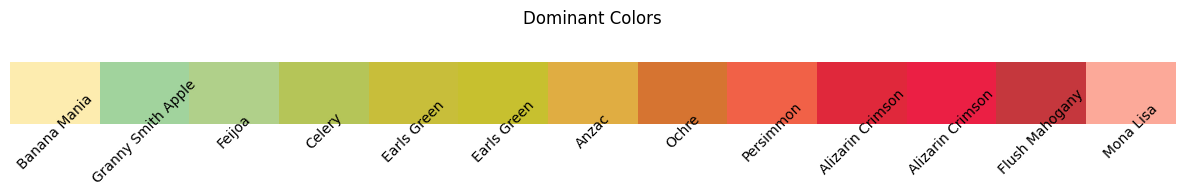


Average optimal k: 7

Running k-means with k=3 for consistency with the next chapter:
Color names for k=3:
Hex code: #fdecaf, Color name: Banana Mania
Hex code: #a5d195, Color name: Feijoa
Hex code: #e16c3e, Color name: Red Damask


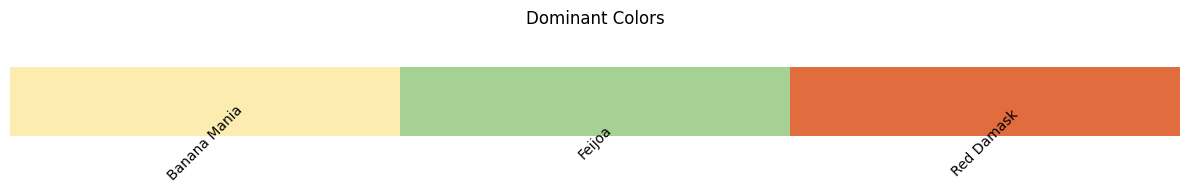

In [38]:
#1. Importing necessary Libraries
import numpy as np  # Numerical operations
import pandas as pd  # Data manipulation and analysis
import matplotlib.pyplot as plt  # Plotting
from mpl_toolkits.mplot3d import Axes3D  # 3D plotting
import cv2  # Image processing
from sklearn.cluster import KMeans  # K-means clustering algorithm
from sklearn.metrics import silhouette_score  # Silhouette score for clustering evaluation
from kneed import KneeLocator  # Finding the "knee" in a curve
import webcolors  # Working with color names
from collections import Counter  # Counting hashable objects
import json  # JSON manipulation
import math  # Mathematical functions
import warnings  # Warning control

#2. Define the helper functions for coneverting RGB to HEX and vice versa
# Converts a color from RGB format to HEX format
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))
# Loads an image from the given path and converts it to RGB color space
def load_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"No image found at {image_path}")
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Preprocesses the image by resizing it and converting it to a format suitable for analysis
def preprocess_image(image, target_size=(600, 400)):
    resized = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)
    return resized.reshape(-1, 3)
# Loads and preprocesses the image, and optionally displays the original and processed image
def load_and_preprocess(image_path, plot=True):
    original = load_image(image_path)
    processed = preprocess_image(original)
    if plot:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.imshow(original)
        ax1.set_title("Original Image")
        ax1.axis('off')
        ax2.imshow(processed.reshape(400, 600, 3))
        ax2.set_title("Preprocessed Image")
        ax2.axis('off')
        plt.show()
    return original, processed

# Extracts the dominant colors from the image using the K-means algorithm
def extract_colors(image, n_colors, n_init=10, random_state=42):
    # Apply K-means clustering to find dominant colors
    kmeans = KMeans(n_clusters=n_colors, n_init=n_init, random_state=random_state)
    # Assigns each pixel to the closest cluster center
    labels = kmeans.fit_predict(image)
    
    # Count how many pixels belong to each cluster using Counter
    counts = Counter(labels)
    
    # Get the RGB values of cluster centers (dominant colors)
    center_colors = kmeans.cluster_centers_
    
    # Order colors by their frequency of occurrence in the image
    ordered_colors = [center_colors[i] for i in counts.keys()]
    
    # Convert to integer RGB values and hex codes
    rgb_colors = [color.astype(int) for color in ordered_colors]
    hex_colors = [RGB2HEX(color) for color in rgb_colors]
    
    return rgb_colors, hex_colors, labels


#3 Load color names
with open('colors_name.json') as json_file:
    json_data = json.load(json_file)

#4 Define color extraction and naming functions
# Finds the name of a color based on the HEX code
def get_colour_name(requested_hex):
    try:
        closest_name = actual_name = json_data[requested_hex.lstrip('#')]
    except KeyError:
        closest_name = closest_colour(webcolors.hex_to_rgb(requested_hex))
        actual_name = None
    return actual_name, closest_name

# Finds the closest color to the requested color based on Euclidean distance
def closest_colour(requested_colour):
    # Calculate the Euclidean distance between the requested color and all available colors
    min_colors = {}
    for key, name in json_data.items():
        # Convert hex to RGB to calculate Euclidean distance
        r_c, g_c, b_c = webcolors.hex_to_rgb("#"+key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colors[math.sqrt(rd + gd + bd)] = name
        # Return the color name with the smallest Euclidean distance
    return min_colors[min(min_colors.keys())]

#5 Define visualization functions
# Plots a bar with the dominant colors and their names
def plot_color_bar(hex_colors, color_names):
    fig, ax = plt.subplots(figsize=(12, 2))
    for i, (hex_color, name) in enumerate(zip(hex_colors, color_names)):
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, facecolor=hex_color))
        ax.text(i+0.5, -0.1, name, ha='center', va='center', rotation=45)
    ax.set_xlim(0, len(hex_colors))
    ax.set_ylim(-0.5, 1.5)
    ax.axis('off')
    plt.title('Dominant Colors')
    plt.tight_layout()
    plt.show()

# Plots a 3D scatter plot of the image's colors
def plot_3d_scatter(image):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    pixel_colors = image.reshape(-1, 3) / 255.0
    ax.scatter(pixel_colors[:, 0], pixel_colors[:, 1], pixel_colors[:, 2], c=pixel_colors, s=1)
    ax.set_xlabel('Red')
    ax.set_ylabel('Green')
    ax.set_zlabel('Blue')
    plt.title('3D RGB Color Space')
    plt.show()

#6 Implement Elbow Method
# Apply the elbow method to find the optimal number of clusters
def elbow_method(image, max_k=10):
    distortions = []
    K = range(1, max_k + 1)
    
    # Calculate distortion for different k values
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(image)
        distortions.append(kmeans.inertia_)
    
    # Use KneeLocator to find the elbow point
    kn = KneeLocator(K, distortions, curve='convex', direction='decreasing')
    optimal_k = kn.elbow
    
    # Plot the elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('Elbow Method for Optimal k')
    plt.vlines(optimal_k, plt.ylim()[0], plt.ylim()[1], colors='r', linestyles='dashed', label=f'Optimal k={optimal_k}')
    plt.legend()
    plt.show()
    
    return optimal_k

#7 Implement Silhouette Method
# Apply the Silhouette method to find the optimal number of clusters
def silhouette_method(image, max_k=10):
    silhouette_scores = []
    K = range(2, max_k + 1)
    
    # Calculate silhouette score for different k values
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(image)
        score = silhouette_score(image, labels)
        silhouette_scores.append(score)
    
    # Find k with highest silhouette score
    optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2
    
    # Plot silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(K, silhouette_scores, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Analysis for Optimal k')
    plt.vlines(optimal_k, plt.ylim()[0], plt.ylim()[1], colors='r', linestyles='dashed', label=f'Optimal k={optimal_k}')
    plt.legend()
    plt.show()
    
    return optimal_k

#8 Implement Gap Statistic Method
# Applies the Gap Statistic method to find the optimal number of clusters"
def gap_statistic(image, nrefs=3, maxClusters=15):
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount': [], 'gap': []})
    for gap_index, k in enumerate(range(1, maxClusters)):
        # Calculate the gap statistic for k
        refDisps = np.zeros(nrefs)
        for i in range(nrefs):
            # Generate random reference data set
            randomReference = np.random.random_sample(size=image.shape) 
            km = KMeans(k) # Fit the KMeans model to the reference data set
            km.fit(randomReference) 
            refDisp = km.inertia_ # Calculate the dispersion of the reference data set
            refDisps[i] = refDisp # Fit the KMeans model to the actual data set
        km = KMeans(k)
        km.fit(image)
        origDisp = km.inertia_
        gap = np.log(np.mean(refDisps)) - np.log(origDisp) # Calculate the gap statistic
        gaps[gap_index] = gap # Store the results 
        resultsdf = pd.concat([resultsdf, pd.DataFrame({'clusterCount': [k], 'gap': [gap]})], ignore_index=True) 
    optimal_k = gaps.argmax() + 1 
    # Plot the gap statistic curve
    plt.figure(figsize=(10, 6))
    plt.plot(resultsdf['clusterCount'], resultsdf['gap'], linestyle='--', marker='o', color='b')
    plt.xlabel('k')
    plt.ylabel('Gap Statistic')
    plt.title('Gap Statistic vs. K')
    plt.vlines(optimal_k, plt.ylim()[0], plt.ylim()[1], colors='r', linestyles='dashed', label=f'Optimal k={optimal_k}')
    plt.legend()
    plt.show()
    return optimal_k

#9 Define method execution and result display function
def run_method(image, method_func, method_name):
    optimal_k = method_func(image) # Find optimal k
    rgb_colors, hex_colors, labels = extract_colors(image, optimal_k) # Extract colors 
    color_names = [get_colour_name(hex_color)[1] for hex_color in hex_colors] # Get color names 
    # Display results
    print(f"\n{method_name} Results:")
    print(f"Optimal k: {optimal_k}")
    print("Color names for each hex code:")
    for hex_color, name in zip(hex_colors, color_names):
        print(f"Hex code: {hex_color}, Color name: {name}")
    
    plot_color_bar(hex_colors, color_names)
    
    # Add pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(np.bincount(labels), colors=hex_colors, labels=color_names, autopct='%1.1f%%')
    plt.title(f'Color Distribution ({method_name})')
    plt.show()
    
    # Add cluster visualization
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(image[:, 0], image[:, 1], image[:, 2], c=labels, cmap='viridis')
    ax.set_xlabel('Red')
    ax.set_ylabel('Green')
    ax.set_zlabel('Blue')
    plt.colorbar(scatter)
    plt.title(f'K-means Clustering on Image ({method_name})')
    plt.show()
    
    return optimal_k

#10 Define main analysis function
def main_analysis(image_path):
    original, processed = load_and_preprocess(image_path)
    plot_3d_scatter(processed)
    
    # Run each method separately
    k_elbow = run_method(processed, elbow_method, "Elbow Method")
    k_silhouette = run_method(processed, silhouette_method, "Silhouette Method")
    k_gap = run_method(processed, gap_statistic, "Gap Statistic Method")
    
    # Calculate average optimal k
    k_average = int(np.mean([k_elbow, k_silhouette, k_gap]))
    print(f"\nAverage optimal k: {k_average}")
    
    # Run k-means with k=3 for consistency with subsequent analysis
    print("\nRunning k-means with k=3 for consistency with the next chapter:")
    rgb_colors, hex_colors, labels = extract_colors(processed, 3)
    color_names = [get_colour_name(hex_color)[1] for hex_color in hex_colors]
    
    print("Color names for k=3:")
    for hex_color, name in zip(hex_colors, color_names):
        print(f"Hex code: {hex_color}, Color name: {name}")
    
    plot_color_bar(hex_colors, color_names)
    
    # Add pie chart for k=3
    plt.figure(figsize=(8, 8))
    plt.pie(np.bincount(labels), colors=hex_colors, labels=color_names, autopct='%1.1f%%')
    plt.title('Color Distribution (k=3)')
    plt.show()
    
    # Visualize k-means clustering results with k=3
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(processed[:, 0], processed[:, 1], processed[:, 2], c=labels, cmap='viridis')
    ax.set_xlabel('Red')
    ax.set_ylabel('Green')
    ax.set_zlabel('Blue')
    
    # Plot centroids to show cluster centers
    centroids = KMeans(n_clusters=3, random_state=42).fit(processed).cluster_centers_
    ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c='red', s=200, alpha=0.75, label='Centroids')
    
    plt.colorbar(scatter)
    plt.title('K-means Clustering on Image (k=3)')
    plt.legend()
    plt.show()
    
#11 Execute main analysis
main_analysis(r'C:\Biography\ArtEmotionalPalette-AI\images_jpg\colors.jpg')

# 10. Conclusion

This notebook demonstrated a comprehensive approach to color analysis using K-means clustering.
We implemented and compared three methods for determining the optimal number of clusters:
Elbow, Silhouette, and Gap Statistic. While these methods provided insights into the optimal
number of clusters, we ultimately used k=3 for the final analysis to maintain consistency
with the next chapter of the diplomatic work.

The analysis with k=3 extracted the three most dominant colors from the image, which were
then matched to named colors and associated with both positive and negative emotions.

Key findings:

1. Comparison of optimal k values from different methods
2. Extraction of three dominant colors
3. Association of colors with named colors and emotions

Limitations:

1. Fixed use of k=3 may not always represent the optimal clustering for all images
2. Simplified color-emotion mappings may not capture the full complexity of color psychology
